In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Data/archive.zip

Streaming output truncated to the last 5000 lines.
  inflating: seg_train/seg_train/mountain/7506.jpg  
  inflating: seg_train/seg_train/mountain/7537.jpg  
  inflating: seg_train/seg_train/mountain/7539.jpg  
  inflating: seg_train/seg_train/mountain/7551.jpg  
  inflating: seg_train/seg_train/mountain/7560.jpg  
  inflating: seg_train/seg_train/mountain/7565.jpg  
  inflating: seg_train/seg_train/mountain/7578.jpg  
  inflating: seg_train/seg_train/mountain/7581.jpg  
  inflating: seg_train/seg_train/mountain/7586.jpg  
  inflating: seg_train/seg_train/mountain/7647.jpg  
  inflating: seg_train/seg_train/mountain/7652.jpg  
  inflating: seg_train/seg_train/mountain/7654.jpg  
  inflating: seg_train/seg_train/mountain/7662.jpg  
  inflating: seg_train/seg_train/mountain/767.jpg  
  inflating: seg_train/seg_train/mountain/7672.jpg  
  inflating: seg_train/seg_train/mountain/7679.jpg  
  inflating: seg_train/seg_train/mountain/7681.jpg  
  inflating: seg_train/seg_train/mountain/7693.jp

In [6]:
import tensorflow as tf  # defining and training neural networks.
from timeit import default_timer as timer # measure the time taken for certain operations
import numpy as np # numerical operations

import pandas as pd # data manipulation and analysis library

from tensorflow import keras # Keras neural networks API, simplifying model construction.

from keras.applications import ResNet50
from keras.preprocessing import image
#  pre-trained models like ResNet50 and image-related operations.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
#  data augmentation, artificially increasing the size of the training dataset.

from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
#building models and implementing training callbacks.

from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization, LSTM, ConvLSTM2D
# constructing the architecture of the neural network.

from keras.losses import categorical_crossentropy
# Categorical crossentropy is a common loss function for multi-class classification problems.

In [3]:
# paths of data
train_path = 'seg_train/seg_train'
test_path = 'seg_test/seg_test'
pred_path = 'seg_pred/seg_pred'

In [7]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
    rotation_range=20,              # Random rotation within 20 degrees
    width_shift_range=0.2,          # Random horizontal shift by 20% of image width
    height_shift_range=0.2,         # Random vertical shift by 20% of image height
    horizontal_flip=True,           # Random horizontal flipping
    fill_mode='nearest'             # Fill mode for new pixels after shifts/rotations
)

In [8]:
size_images = 150
batch_size = 64

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size=batch_size,           # Number of images in each batch
    seed=32,                         # Optional: Set a random seed for shuffling
    shuffle=True,                    # Shuffle the data during training
    class_mode='categorical'        # Mode for class labels (categorical for one-hot encoding)
)

Found 14034 images belonging to 6 classes.


In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(size_images,size_images),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 3000 images belonging to 6 classes.


In [11]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label in in train and validation datasets\n")

for key, value in labels.items():
    print(f'{key} : {value}')

Label in in train and validation datasets

0 : buildings
1 : forest
2 : glacier
3 : mountain
4 : sea
5 : street


In [12]:

from keras.models import Sequential
model = Sequential()

In [13]:
#convolution matrix 1
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))# kernel of 3*3
model.add(BatchNormalization())# improve the training stability and convergence speed
model.add(MaxPooling2D(pool_size=(2,2)))#pooling layer
model.add(Dropout(0.2))
#convolution matrix 2
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
#convolution matrix 3
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))# prevention from overfitting
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))# softmax:classify inputs into more than two classes.

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,308,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,403,974 (20.61 MB)

 Trainable params: 5,403,270 (20.61 MB)

 Non-trainable params: 704 (2.75 KB)

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience = 5, min_lr =1e-6, verbose=1)

In [17]:
history = model.fit(train_generator, validation_data = validation_generator, batch_size = 64, epochs= 15, verbose = 1)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 111s 450ms/step - accuracy: 0.5661 - loss: 1.2198 - val_accuracy: 0.1760 - val_loss: 4.9677
Epoch 2/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 91s 412ms/step - accuracy: 0.7175 - loss: 0.7576 - val_accuracy: 0.4673 - val_loss: 1.9753
Epoch 3/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 90s 410ms/step - accuracy: 0.7480 - loss: 0.6909 - val_accuracy: 0.6543 - val_loss: 1.1260
Epoch 4/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 89s 405ms/step - accuracy: 0.7634 - loss: 0.6348 - val_accuracy: 0.6370 - val_loss: 1.3953
Epoch 5/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 91s 415ms/step - accuracy: 0.7988 - loss: 0.5559 - val_accuracy: 0.7850 - val_loss: 0.5611
Epoch 6/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 90s 410ms/step - accuracy: 0.8115 - loss: 0.5271 - val_accuracy: 0.6700 - val_loss: 1.0088
Epoch 7/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 98s 446ms/step - accuracy: 0.8161 - loss: 0.4959 - val_accuracy: 0.8213 - val_loss: 0.5470
Epoch 8/15
220/220 ━━━━━━━━━━━━━━━━━━━━ 91s 413ms/step - accuracy: 0.8243 - loss: 

In [18]:
model.evaluate(validation_generator)


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.8417 - loss: 0.4652


[0.4700451195240021, 0.8433333039283752]

In [19]:
import os
from PIL import Image
pred_img_list = [f"seg_pred/seg_pred/{i}" for i in os.listdir("seg_pred/seg_pred")]

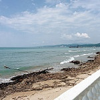

0
buildings


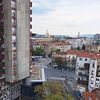

0
buildings


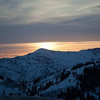

0
buildings


In [26]:
import random
from random import randint

for i in range(3):
  num = random.randint(0, len(pred_img_list))
  img = Image.open(pred_img_list[num])
  display(img.resize((100,100)))
  img = img.resize((150, 150))
  img_array = np.array(img)
  img_array = img_array[np.newaxis, :]
  prob = model(img_array)

  pred = np.argmax(prob)
  print(pred)
  print(labels[pred])



In [24]:
model.compile(optimizer='adam', loss='mean_squared_error')

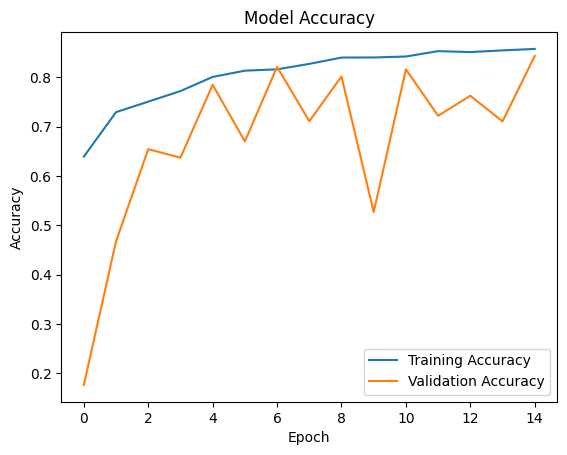

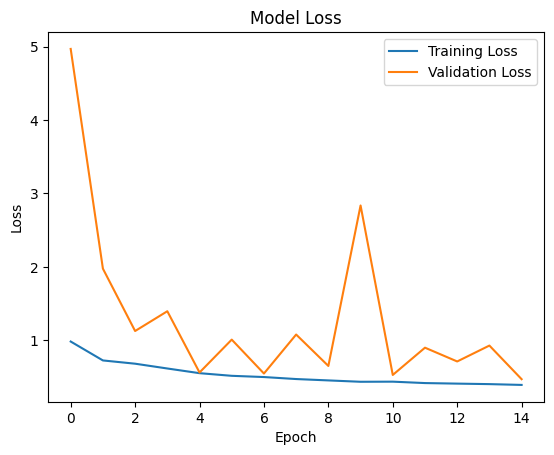

In [22]:
import matplotlib.pyplot as plt

# Assuming 'history' is a dictionary with keys 'accuracy', 'val_accuracy', 'loss', 'val_loss'
# Make sure it's defined and contains the expected data

# Plotting training & validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plotting training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()
